In [22]:
%matplotlib inline
import os
from collections import OrderedDict
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV
import random as rd
from scipy.spatial import distance
from scipy.stats import pearsonr
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [24]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [16]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'cca_zoo_old',
 'data.json',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'GNPS_spectra_toconfirm',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_corr',
 'ms2ds_pred_cos.filepart',
 'ms2ds_pred_euc',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_202

In [25]:
class RunCCA:
    def __init__(self, view1, view2,dims=2):
        self.v1 = view1
        self.v2 = view2
        self.dims = dims
    
    def train_cca(self):
        # step 0: init the model
        linear_cca = CCA(latent_dims=self.dims,scale=False)
        
        # step 1: train (fit and transform)
        train_z1, train_z2 = linear_cca.fit_transform([self.v1, self.v2])
        
        #step 3: extract correlation between the dims of the 2 views
        train_corr = linear_cca.score([self.v1, self.v2])
        
        # bundle them in dfs
        
        # 1 latent_spaces
        train_latent_spaces = pd.DataFrame(list(zip(train_z1,train_z2)),\
                      columns=['train_z1','train_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        train_cor_df = pd.DataFrame(list(zip(dims,train_corr)),\
                      columns=['latent_dim','cor'])
        
        return linear_cca, train_latent_spaces, train_cor_df
        
    def test_cca(self, model):
            
            
        # transform the test dataset
        test_z1, test_z2 = model.transform([self.v1,self.v2])
        test_corr = model.score([self.v1, self.v2])
            
        # bundle them in dfs
        
        # 1 latent_spaces
        test_latent_spaces = pd.DataFrame(list(zip(test_z1,test_z2)),\
                      columns=['test_z1','test_z2'])
        
        # 2 corr pd for plotting
        dims = [i for i in range(1,self.dims+1)] # adding 1 to start from 1
        test_cor_df = pd.DataFrame(list(zip(dims,test_corr)),\
                          columns=['latent_dim','cor'])
        
        return test_latent_spaces, test_cor_df
         

### Train A CCA model with MS2DeepScore embeddings

#### 1. Unfiltered Embeddings

In [26]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:10000] #just a subset for scripting
df_all.shape

(41447, 8)

In [265]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
#df_all.shape

In [27]:
#split the dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

v1_train, v1_test = [x for x in train_df['ms2ds']], [x for x in test_df['ms2ds']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [267]:
#rd.shuffle(v1_train)


In [28]:
# train the model
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.906207
1,2,0.834931
2,3,0.789191
3,4,0.770649
4,5,0.742032


In [30]:
# test the model
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.895282
1,2,0.819656
2,3,0.778438
3,4,0.746195
4,5,0.727633


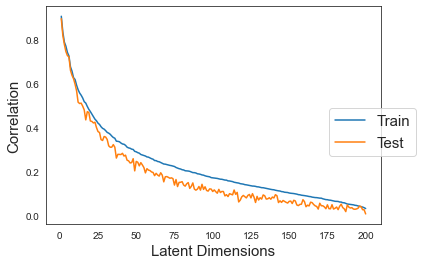

In [31]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)

plt.show()

### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [53]:
def predict(metric='euc'):

    preds = {}

    for index, query in enumerate(tqdm(test_dims['test_z1'])):
    
        preds[index] = []
        for subject in train_dim['train_z2']:
        
    
            if metric == 'corr':
                corr = pearsonr(query[0:25], subject[0:25])[0]
                preds[index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[0:25], subject[0:25])
                preds[index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[0:25], subject[0:25])
                preds[index].append(cos)
    # you might want to sort preds and return only top hits for better memory
    return preds
    

In [33]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [34]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [35]:
def get_tanimotos(preditions_dict, metric):
    tanimotos = []
    for query_index, values in tqdm(preditions_dict.items()):
    
        #select top 5 hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:5]
        #select closest 5 hits for each query based on cosine/euclidian distance
        else:
            top_hits = np.sort(values)[:5]
    
        #calculate tanimoto scores for each of the top 5 hits
        top_hits_scores = []
        for hit in top_hits:
        
            subject_index = values.index(hit)
            smile1 = train_df['smiles'].iloc[subject_index]
            smile2= test_df['smiles'].iloc[query_index]
            top_hits_scores.append(tanimoto(smile1,smile2))
        #select the max tanimoto score 
        tanimotos.append(max(top_hits_scores))
    return tanimotos
    

#### Method 1: Euclidean Distance

In [ ]:
#calculate Euclidean predictions
ms2ds_pred_euc = predict('euc')

# write to file
path = './ms2ds_pred_euc'
Files(path).write_to_file(ms2ds_pred_euc)


#calculate Euclidean tanimotos 
euc_ms2ds_tanimotos = get_tanimotos(ms2ds_preds_euc, 'euc')

#write tanimotos to file 
path = './ms2ds_pred_euc_tanimoto'
Files(path).write_to_file(euc_ms2ds_tanimotos)

#### Method 2: Cosine Distance

In [89]:
#calculate cosine predictions
ms2ds_pred_cos = predict('cos')

# write to file
path = './ms2ds_pred_cos'
Files(path).write_to_file(ms2ds_pred_cos)


#calculate cosine tanimotos 
cos_ms2ds_tanimotos = get_tanimotos(ms2ds_preds_cos, 'cos')

#write tanimotos to file 
path = './ms2ds_pred_cos_tanimoto'
Files(path).write_to_file(cos_ms2ds_tanimotos)

100%|██████████████████████████████████████████████████████████████████████████| 12435/12435 [2:25:40<00:00,  1.42it/s]


#### Method 3: Correlation 

In [ ]:
#calculate correlation prediction
ms2ds_pred_corr = predict('corr')

# write to file
path = './ms2ds_pred_corr'
Files(path).write_to_file(ms2ds_pred_corr)


#calculate correlation tanimotos 
corr_ms2ds_tanimotos = get_tanimotos(ms2ds_preds_corr, 'corr')

#write tanimotos to file 
path = './ms2ds_pred_corr_tanimoto'
Files(path).write_to_file(corr_ms2ds_tanimotos)

 64%|██████████████████████████████████████████████▊                          | 7971/12435 [2:55:11<1:20:52,  1.09s/it]

#### Load in the calculated tanimoto scores for comparison

In [50]:
#load in the generated ms2ds prediction 
path = './ms2ds_pred_euc_tanimoto'
euc_ms2ds_tanimotos = Files(path).load_pickle()

path = './ms2ds_pred_corr_tanimoto'
corr_ms2ds_tanimotos = Files(path).load_pickle()

path = './ms2ds_pred_cos_tanimoto'
cos_ms2ds_tanimotos = Files(path).load_pickle()

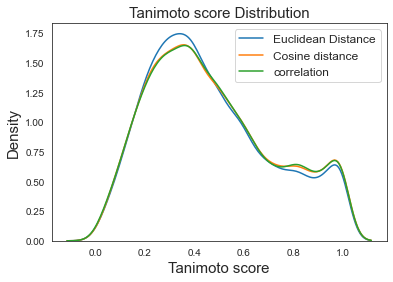

In [52]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [euc_ms2ds_tanimotos,cos_ms2ds_tanimotos, corr_ms2ds_tanimotos]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=False)
plt.legend(labels=['Euclidean Distance','Cosine distance',\
                   'correlation'], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.show()

#### Draw Random predicted molecule

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw

In [15]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'compound_0.png',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_euc',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.m

In [18]:
#load in the generated ms2ds prediction 
path = './ms2ds_pred_euc'
ms2ds_preds_euc = Files(path).load_pickle()

In [25]:
#calculate tanimoto scores
ms2ds_preds_tanimotos = get_tanimotos(ms2ds_preds_euc, 'euc')

100%|████████████████████████████████████████████████████████████████████████████| 12435/12435 [07:04<00:00, 29.27it/s]


In [27]:
import random
keys = random.sample(ms2ds_preds_euc.keys(),5)
sample_dict = {key: ms2ds_preds_euc[key] for key in keys}

C:\Users\lmeli\AppData\Local\Temp/ipykernel_11028/3792517325.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(ms2ds_preds_euc.keys(),5)


In [28]:
len(sample_dict)

5

In [14]:
#pick random pairs to draw
smile = train_df['smiles'][0]
m = Chem.MolFromSmiles(smile)
Draw.MolToFile(m, f"compound_{0}.png")

In [47]:
#function to draw structuctures

scores = []
os.chdir('../compounds')
for query_index, values in tqdm(sample_dict.items()):
    top_hits = np.sort(values)[:5]
    tanimotos = []
    #draw the query
    query_smile= test_df['smiles'].iloc[query_index]
    query_class = test_df['cf_class'].iloc[query_index]
    query = Chem.MolFromSmiles(query_smile)
    Draw.MolToFile(query, f"query_{query_index}_{query_class}.png")
    #draw top 5 hits
    for hit_index, hit in enumerate(top_hits):
        subject_index = values.index(hit)
        subject_smile = train_df['smiles'].iloc[subject_index]
        subject_class = train_df['cf_class'].iloc[subject_index]
        
        subject = Chem.MolFromSmiles(subject_smile)
        Draw.MolToFile(subject, f"query_{query_index}_hit_{hit_index}_{subject_class}.png")
        if query_index == 6679 or 4255:
        #calculate tanimotos for the sampled query and subject
            tanimotos.append(tanimoto(query_smile,subject_smile))
    scores.append([(query_index),tanimotos])
        
        
os.chdir('../raw_data')        

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


In [48]:
scores

[[6679, [0.6275, 0.6719, 0.6991, 0.6991, 0.6991]],
 [4255, [0.4674, 0.5358, 0.5358, 0.5358, 0.4627]],
 [11916, [0.6543, 0.9262, 0.6407, 0.6306, 0.6297]],
 [12281, [0.3221, 0.3221, 0.2946, 0.1849, 0.1972]],
 [12167, [0.2442, 0.2078, 0.2078, 0.2167, 0.2004]]]

#### 2. filtered Embeddings

In [89]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_uniq = Files(path).load_pickle()#[:10000] #just a subset for scripting
df_uniq.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,spec_id0,"[-22.561352524375522, -52.61297182073491, 49.4...","[0.0, 15.901467323303223, 37.36699676513672, 0...","[1.630672, -6.694838, -8.602699, 8.267098, 5.2...",Peptidomimetics
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,spec_id1,"[-8.144101929166954, -25.09254423476226, -1.49...","[0.0, 3.603170394897461, 12.24513053894043, 0....","[-2.5071416, -7.008046, -7.7435217, 3.9533424,...",Peptidomimetics
2,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,spec_id2,"[-5.008793063971317, 32.11217206150628, -8.982...","[0.0, 0.0, 2.6736814975738525, 0.0, 0.0, 0.0, ...","[-0.3728091, -9.532841, -10.665195, 17.613012,...",Macrolactams
3,CC(C)C[C@@H]1OC(=O)[C@@H]2CCCN2C(=O)[C@H](CC2=...,GWGKNTICBPKKKW-LBBUGJAGSA-N,GWGKNTICBPKKKW,spec_id3,"[16.967691713559265, 11.406365395323293, -5.16...","[0.0, 0.0, 8.311530113220215, 21.6807460784912...","[5.140757, -10.130683, -8.369965, 13.165277, -...",Peptidomimetics
4,CCCCCCCCCCCCCC(=O)NC(C)(C)C(=O)N1C[C@H](O)C[C@...,FFCLYSVFZQXUHI-XUVLUQBSSA-N,FFCLYSVFZQXUHI,spec_id4,"[-32.38097167038966, -11.560462254295976, -4.1...","[0.0, 2.4228768348693848, 17.64068031311035, 0...","[-6.1560755, -6.321531, -5.7416663, -6.0778522...",Carboxylic acids and derivatives


In [90]:
#split the dataset
train_df, test_df = \
train_test_split(df_uniq, test_size=0.2, \
                 random_state=42)

v1_train, v1_test = [x for x in train_df['ms2ds']], [x for x in test_df['ms2ds']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [10]:
# # normalising slightly improves spec2vec but slightly decreases ms2ds
# v1_train, v1_test = normalize(v1_train), normalize(v1_test)
# v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [91]:
# train the model
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.899808
1,2,0.844028
2,3,0.806704
3,4,0.797919
4,5,0.753063


In [92]:
# test the model
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.889260
1,2,0.826607
2,3,0.769665
3,4,0.785805
4,5,0.740144


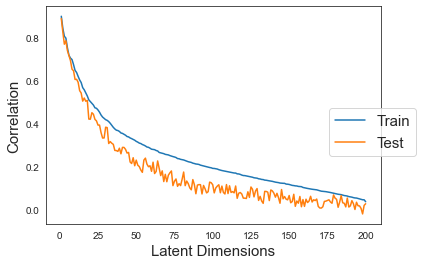

In [93]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)

plt.show()

The validation function used here was downloaded from [CCA_zoo](https://cca-zoo.readthedocs.io/en/latest/auto_examples/plot_validation.html#sphx-glr-auto-examples-plot-validation-py) documentation; same function can also be found in [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) documentation

In [276]:
from cca_zoo.model_selection import permutation_test_score
from plot_validation import plot_learning_curve
from sklearn.model_selection import KFold, ShuffleSplit


In [277]:
v1_train = np.array(v1_train)
v2_train = np.array(v2_train)

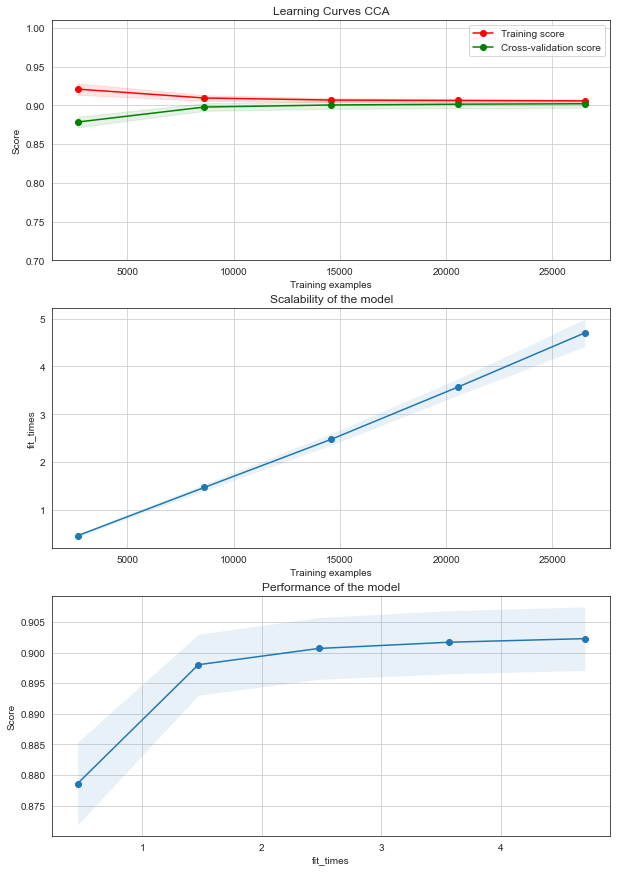

In [278]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves CCA"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
model = CCA()
plot_learning_curve(model, title, \
                    (v1_train, v2_train), axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()



### Train A CCA model with Spec2vec embeddings

#### 1. Unfiltered spec2vec Embeddings

In [279]:
#split the dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['inchikey14'])

v1_train, v1_test = [x for x in train_df['spec2vec']], [x for x in test_df['spec2vec']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [281]:
# normalising slightly improves spec2vec but slightly decreases ms2ds
v1_train, v1_test = normalize(v1_train), normalize(v1_test)
v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [282]:
# train the model with spec2vec unfiltered embeddings
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.784851
1,2,0.737054
2,3,0.700809
3,4,0.662728
4,5,0.643240


In [283]:
# test the model (unfiltered spec2vec)
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.772790
1,2,0.725572
2,3,0.688245
3,4,0.646513
4,5,0.619302


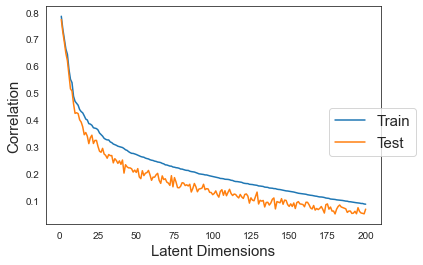

In [284]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)

plt.show()

#### 2. Filtered Spec2vec Embeddings

In [169]:
#split the dataset (filtered spec2vec)
train_df, test_df = \
train_test_split(df_uniq, test_size=0.2, \
                 random_state=42)

v1_train, v1_test = [x for x in train_df['spec2vec']], [x for x in test_df['spec2vec']]
v2_train, v2_test = [x for x in train_df['mol2vec']], [x for x in test_df['mol2vec']]

In [170]:
# normalizing slightly improves spec2vec
v1_train, v1_test = normalize(v1_train), normalize(v1_test)
v2_train, v2_test =  normalize(v2_train), normalize(v2_test)

In [171]:
# train the model with spec2vec filtered embeddings
model, train_dim, train_corr = RunCCA(v1_train, v2_train, dims=200).train_cca()
train_corr.head()

,latent_dim,cor
0,1,0.801794
1,2,0.741277
2,3,0.722125
3,4,0.686932
4,5,0.648152


In [28]:
# test the model (filtered spec2vec)
test_dims, test_corr = RunCCA(v1_test, v2_test,dims=200).test_cca(model)
test_corr.head()

,latent_dim,cor
0,1,0.791494
1,2,0.713723
2,3,0.685799
3,4,0.641021
4,5,0.624926


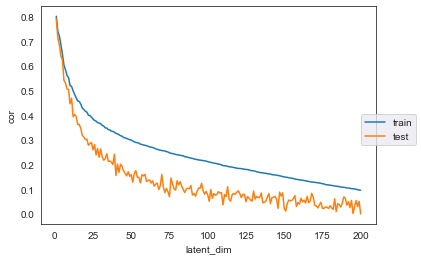

In [29]:
# plot train correlation vs test correlation
fig, ax = plt.subplots()
sns.set_style('white')
dfs = [train_corr,test_corr]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)

plt.show()

In [21]:
v1_train = np.array(v1_train)
v2_train = np.array(v2_train)

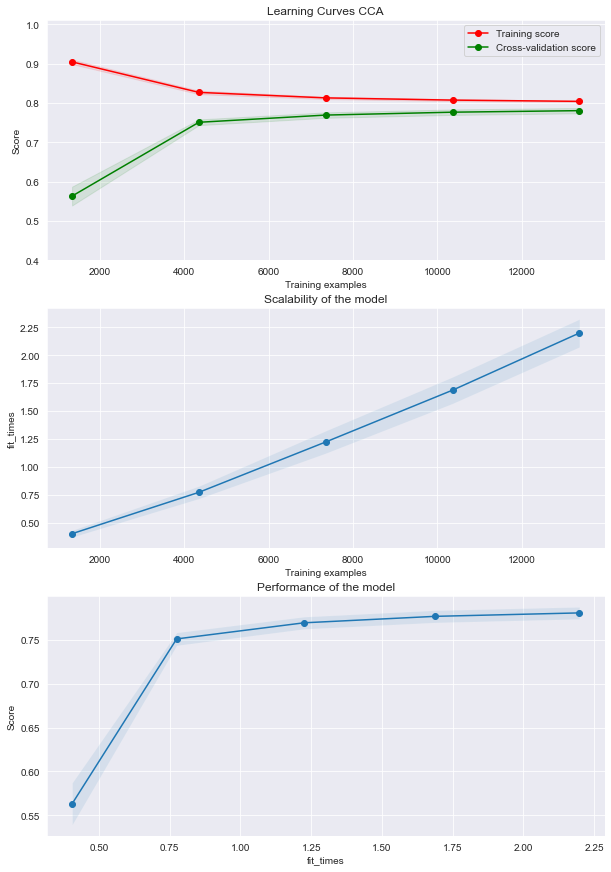

In [35]:

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves CCA"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
model = CCA()
plot_learning_curve(model, title, \
                    (v1_train, v2_train), axes=axes, ylim=(0.4, 1.01), cv=cv, n_jobs=4)
plt.show()

### Prediction

#### 1. Euclidian Distance

In [70]:
np.argmax(predicted_corr)

5116

In [71]:
train_df['cf_class'][5116]

'Tannins'

In [54]:
cor = np.corrcoef(test_dims['test_z1'][0], train_dim['train_z1'][0])[0,1]
cor

-0.049430581683456515

In [51]:
from scipy.stats import pearsonr

In [52]:
cor = pearsonr(test_dims['test_z1'][0], train_dim['train_z1'][0])
cor

(-0.04943058168345654, 0.48699429178046516)